# Information Extraction with Graph Convolutional Netowork
* * *
This notebook shows how to train a GCN classifier to tag text the items that OCR has extracted from a set of scanned receipts.

The receipts are part of the SROIE 2019 public dataset. For each labeled image, the dataset contains 3 files:

1. Image: a JPG file with the scanned receipt
2. Word Areas: a text file for each image, containing a list of words and the pixel coordinates of each word (called bounding box); this text file is already extracted with an OCR engine.
3. Labels: for each image, a jason file with tags on some of the fields. n the OCR dataset, the labels contain 4 fields: 
    - company
    * date
    * address
    * total

At the end of this notebook, a deep learning classifier is trained to assign tags to the text areas of unlabeled images.
- The input to the GCN model are the word areas files and the labels files. There is no need to read the image files because the word area files contain all the data needed to compute the features (predictors) that will be used by the GCN model.
- The output of the GCN model is a file containing tags (class) assigned to each word area of the unlabeled examples, this output is similar to the label files. The classes are as follows:
    - company
    * date
    * address
    * total
    * undefined

The "undefined" class is assiged to those words that are neither of the 4 classes that the model is trained to recognize.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../python'))

In [2]:
# libraries
from pathlib import Path
from collections import namedtuple
import cv2 

# python modules
from data_access import *
from visuals import *
from graph_modeler import *
from feature_calculator import *

# Globals
from global_parameters import UNDEFINED, WordArea

# configs for data storage
PROJECT_ROOT_PREFIX = os.path.abspath('../')
NORMALIZED_PREFIX = "data/sroie2019/normalized/"
normalized_dir = os.path.join(PROJECT_ROOT_PREFIX, NORMALIZED_PREFIX)
FEATURES_PREFIX = "data/sroie2019/"
features_dir = os.path.join(PROJECT_ROOT_PREFIX, FEATURES_PREFIX)

### Input Example
* * *
- For each word area, the bounding box is represented as a blue rectangle, the text inside the rectangle is the content of the word area.
* For each tagged word, the tag name is printed in red above the corresponding word area.

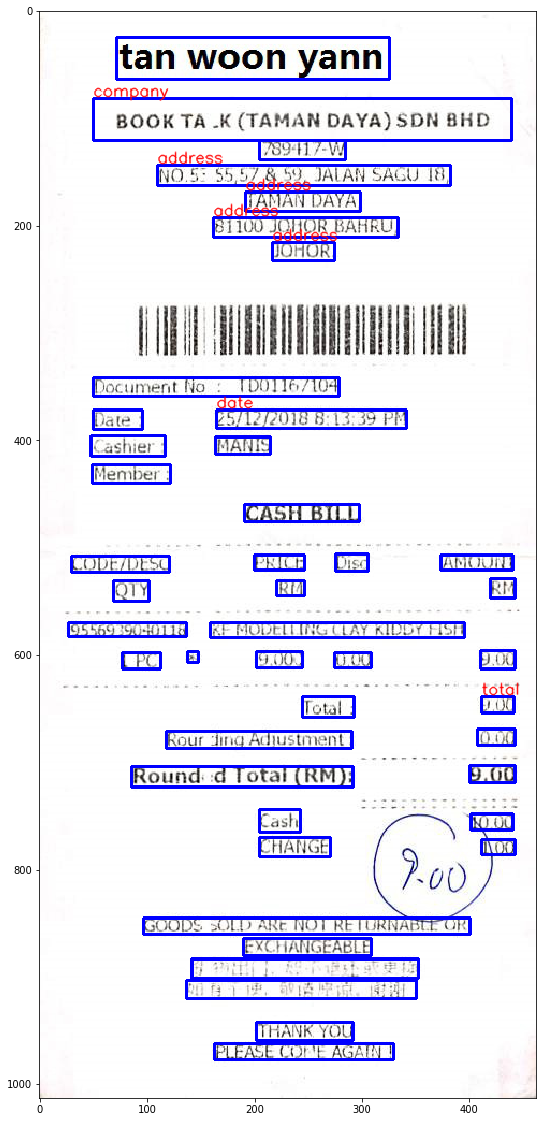

In [3]:
# find the data files
image_files, word_files, entity_files = get_normalized_filepaths(normalized_dir)

# load one example
image, word_areas, entities = load_normalized_example(image_files[0], word_files[0], entity_files[0])
        
# show image with annotations
plot_image(image, word_areas, entities)

# Pipeline
* * *
The Information Extraction pipeline consists of the following steps:
1. Graph Modeler
2. Feature Calculator
3. GCN Training and Prediction

The input to the pipeline is a dataset as described above, where some of the images have tags (field names) as the ones printed in red on the image above, and other images don't have any tags. The first type of images are called "labeled" images, and the second type are called "unlabeled".

All the input images have been processed by an OCR engine and therefore there is a word areas text file for each image with bounding boxes around each word.

### Graph Modeler



8 :	 WordArea(left=50, top=372, right=96, bottom=390, content='DATE:', idx=8)
8 :	 WordArea(left=165, top=372, right=342, bottom=389, content='25/12/2018 8:13:39 PM', idx=9)


9 :	 WordArea(left=48, top=396, right=117, bottom=415, content='CASHIER:', idx=10)
9 :	 WordArea(left=164, top=397, right=215, bottom=413, content='MANIS', idx=11)


12 :	 WordArea(left=30, top=508, right=121, bottom=523, content='CODE/DESC', idx=14)
12 :	 WordArea(left=200, top=507, right=247, bottom=521, content='PRICE', idx=15)
12 :	 WordArea(left=276, top=506, right=306, bottom=522, content='DISC', idx=16)
12 :	 WordArea(left=374, top=507, right=441, bottom=521, content='AMOUNT', idx=17)


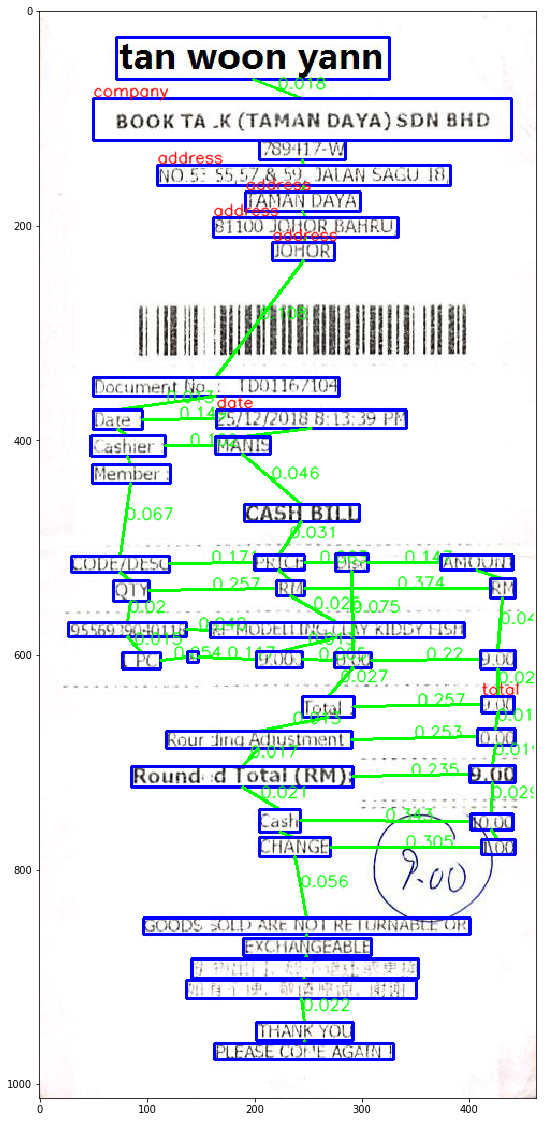

In [4]:
# group words into horizontal lines
lines = line_formation(word_areas)

# show some multi-word lines
counter = 3
for i, line in enumerate(lines):
    if len(line) > 1:
        print('\n')
        for tup in line:
            print(i, ":\t", tup)
        counter -= 1
        if counter == 0: break

# create graph from layout
image_width, image_height = cv_size(image)
graph = graph_modeling(lines, word_areas, image_width, image_height)

# show image with annotations
plot_image(image, word_areas, entities, graph, False)

### Feature Calculator
* * *

In [5]:
# Binary Features
binary_features = [get_word_binary_features(wa.content) for wa in word_areas]

# Numeric Features (neighbour distances from graph)
numeric_features = [get_word_area_numeric_features(wa, graph) for wa in word_areas]

# Text Features
word_embeddings = [get_word_bpe(wa.content, bpemb_en) for wa in word_areas]


# print features for one word
idx=9
print(word_areas[idx].content)
print(len(binary_features[idx]))
print(len(numeric_features[idx]))
print(len(word_embeddings[idx]))

25/12/2018 8:13:39 PM
14
4
300


In [6]:
# Adjacency Matrix
adjacency_matrix = form_adjacency_matrix(graph)

# show matrix
print(adjacency_matrix.shape)
adjacency_matrix

(44, 44)


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Run Feature Calculator
* * *
- find data files
* for each:
    - load example
    - calculate features
    - store features and graph
    - store adjacency matrix

(This process runs from a python script)

# Modeling

## GCN Data Loader
* * *

In [8]:
from gcn.utils import *
from scipy.linalg import block_diag
from scipy import sparse
from global_parameters import UNDEFINED, CLASSES
class2idx = {c:idx for idx, c in enumerate(CLASSES)}

In [9]:
def onehot(idx, num_classes):
    """
    1-hot encoding. 
    """
    encoding = np.zeros(num_classes)
    encoding[1] = 1
    return encoding

def encode_labels(class_indices, num_classes):
    encodings = [onehot(idx, num_classes) for idx in class_indices]
    return np.array(encodings, dtype=np.float)

def form_batch(features_dir):
    """
    Creates a single batch with all the graph instances from the training set. For that purpose, 
    it concatenates all the adjacency matrices into a (sparse) block-diagonal matrix 
    where each block corresponds to the adjacency matrix of one graph instance.
    The individual graph adj matrix can be of different sizes.
    
    Input: a list of M individual graph examples
        - graphs: (list of tuples) a list of length M, where each tuple contains 3 matrices: 
                    1. feature_matrix (N, 318): represents the nodes of the graph (words)
                    2. adjacency_matrix (N, N): represents the edgest of the graph
                    3. labels (N, 1): each element represents the category of a node (word tag)
    
    Output: a single graph containing M non-linkes independent sub-graphs
        - batch: (tuple) A single graph represented as a tuple, containing 3 matrices:
                    1. feature_matrix (M*N, 318) : concatenation of all the input feature matrices
                    2. adjacency_matrix (M*N, M*N): block-diagonal matrix
                    3. labels (M*N, 1): concatenation of all the input labels
    """
    X = []  # batch feature matrix
    A = []  # batch adjacency matrix
    CI = []  # batch class indices (labels)
    
    # maps each row in the output feature_matrix back to the individual graph where the row originated
    # this allows to pool the predicted node scores back into each independent graph
    example_ids = [] 
    
    feature_files, _, adj_matrix_files, entity_fils = get_feature_filepaths(features_dir)
    
    for example_id, (f_file, am_file, e_file) in enumerate(zip(feature_files, adj_matrix_files, entity_files)):
        features, adj_matrix = read_features(f_file, am_file)
        entities = read_normalized_entities(e_file)
        X.append(features)
        A.append(adj_matrix)
        class_indices = np.asarray([[class2idx[entity]] for entity in entities]) 
        CI.append(class_indices)
        
        example_ids.append(example_id)

    X = np.vstack(X)
    A = block_diag(*A)
    CI = np.vstack(CI)
    
    features = sparse.lil_matrix(X)

    return features, A, CI, example_ids

def split_sets(class_indices, class2idx, split=[.4, .2, .4]):
    """
    Splits the dataset according to a split distribution. 
    The split is done over the total number of nodes,
    regardless of which independent graph example the node belongs to.
    
    Although the nodes are "logically" split into 3 subsets (train, validation and test), 
    all the nodes are processed together by the model, so 3 full-sized arrays
    of labels are produced, one for each subset, where the labels 
    from the other subsets are masked (zeros).
    
    """
    # select actual labels (filter UNDEFINED)
    undefined_idx = class2idx[UNDEFINED]
    y_mask = np.array(class_indices != undefined_idx)
    y_idx = np.array([idx for idx, m in enumerate(y_mask) if m])
    
    # randomly select from the labeled nodes indices for each split set
    N = y_idx.shape[0]
    n_train, n_val = int(N*split[0]), int(N*split[1])
    np.random.shuffle(y_idx)
    idx_train = y_idx[:n_train]
    idx_val = y_idx[n_train:n_train + n_val]
    idx_test = y_idx[n_train + n_val:]

    # create a matrix of one-hot encoded labels
    labels = encode_labels(class_indices, len(class2idx))
    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]
    
    print("\nLabels:")
    print("Number of Classes: {}".format(y_train.shape[1]))
    print("Number of Labeled Nodes: {}".format(N))
    print("Number of Training Nodes: {}".format(n_train))
    print("Number of Training Nodes per Class: {}".format(n_train//y_train.shape[1]))

    return y_train, y_val, y_test, train_mask, val_mask, test_mask

def data_loader(features_dir, class2idx):

    features, adj, class_indices, example_id = form_batch(features_dir)

    y_train, y_val, y_test, train_mask, val_mask, test_mask = split_sets(class_indices, class2idx)
    
    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask

## GCN Model Runner
* * *


In [10]:
import time
from gcn.models import GCNX, GCN, MLP
import tensorflow as tf
print(tf.test.is_gpu_available())
tf.__version__

False


'1.13.1'

In [11]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

In [12]:
# Settings
# flags = tf.app.flags
# FLAGS = flags.FLAGS
# flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
# flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
# flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
# flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
# flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
# flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
# flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
# flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
# flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
from global_parameters import FLAGS
FLAGS

TrainingParameters(dataset='receipts', model='gcnx_cheby', learning_rate=0.001, epochs=200, hidden1=16, num_hidden_layers=2, dropout=0.6, weight_decay=0.0005, early_stopping=10, max_degree=3)

## Load data


In [13]:
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = data_loader(features_dir, class2idx)
print("\nFeatures: {}".format(features.shape))
print("Adjacency Matrix: {}".format(adj.shape))
print("Labels: {}".format(y_train.shape))


Labels:
Number of Classes: 5
Number of Labeled Nodes: 3026
Number of Training Nodes: 1210
Number of Training Nodes per Class: 242

Features: (33626, 318)
Adjacency Matrix: (33626, 33626)
Labels: (33626, 5)


## Run Semi-Supervised Training

In [14]:
# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'gcnx_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCNX
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

Calculating Chebyshev polynomials up to order 3...


In [15]:
# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

In [16]:
model = model_func(placeholders, input_dim=features[2][1], logging=True)

Instructions for updating:
Colocations handled automatically by placer.
16 layer 32
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [17]:
# Initialize session
sess = tf.Session()

# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

cost_val, acc_val = [], []

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)
    acc_val.append(acc)

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping:
        if cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
            print(" Validation cost is not improving. Early stopping...")
            break

        if 1.0 == np.mean(acc_val[-(FLAGS.early_stopping+1):-1]):
            print("Validation accuracy reached 1.0. Early stopping...")
            break

print("Optimization Finished!")

# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Epoch: 0001 train_loss= 4.59582 train_acc= 0.50331 val_loss= 1.24911 val_acc= 0.90744 time= 1.06371
Epoch: 0002 train_loss= 5.76676 train_acc= 0.54463 val_loss= 1.05884 val_acc= 0.93884 time= 0.94997
Epoch: 0003 train_loss= 4.52987 train_acc= 0.60909 val_loss= 0.90070 val_acc= 0.96198 time= 0.90574
Epoch: 0004 train_loss= 3.88535 train_acc= 0.61570 val_loss= 0.77479 val_acc= 0.97686 time= 0.95925
Epoch: 0005 train_loss= 4.00559 train_acc= 0.67025 val_loss= 0.65887 val_acc= 0.98182 time= 0.91670
Epoch: 0006 train_loss= 3.03587 train_acc= 0.69256 val_loss= 0.54930 val_acc= 0.98843 time= 0.91692
Epoch: 0007 train_loss= 3.74282 train_acc= 0.71405 val_loss= 0.46569 val_acc= 0.99339 time= 0.94989
Epoch: 0008 train_loss= 1.92925 train_acc= 0.72479 val_loss= 0.42961 val_acc= 0.99669 time= 0.94215
Epoch: 0009 train_loss= 1.94596 train_acc= 0.74793 val_loss= 0.39577 val_acc= 0.99835 time= 0.99061
Epoch: 0010 train_loss= 1.81199 train_acc= 0.79669 val_loss= 0.36575 val_acc= 0.99835 time= 0.94403
